# Walk-Forward Backtesting and Slice Analysis

This notebook implements comprehensive backtesting using walk-forward validation with rolling time windows, along with detailed slice analysis to understand model performance across different data segments.

## Objectives
- **Walk-Forward Validation**: Rolling time-based splits for realistic backtesting
- **Slice Analysis**: Performance analysis across different data segments (time periods, value ranges, categories)
- **Model Stability**: Track performance degradation over time
- **Risk Assessment**: Identify high-risk prediction periods
- **Production Readiness**: Validate model for real-world deployment

## Key Features
- Rolling window backtesting with configurable parameters
- Slice analysis by time periods, price ranges, and categorical features
- Performance metrics tracking over time
- Model stability and drift detection
- Risk assessment and alerting thresholds


In [9]:
# Install required packages if not available
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print(f"✅ {package} installed successfully")
    except Exception as e:
        print(f"⚠️  Could not install {package}: {e}")

# Install pydantic-settings if needed
try:
    import pydantic_settings
    print("✅ pydantic-settings already available")
except ImportError:
    print("Installing pydantic-settings...")
    install_package('pydantic-settings')


✅ pydantic-settings already available


In [10]:
# Import project modules
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Project modules
from pricing_rf.data import load_data, clean_data, get_time_series_cv_splits
from pricing_rf.features import create_feature_pipeline, create_all_features
from pricing_rf.metrics import wape, tail_mae, evaluate_model
from pricing_rf.model import build_rf
from pricing_rf.config import DataConfig
from training.objective import create_objective, create_objective_with_cv

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Data Preparation and Feature Engineering


In [11]:
# Load and prepare data
print("Loading and preparing data for backtesting...")
raw_data = load_data('../data/raw.csv')
cleaned_data = clean_data(raw_data)

print(f"Raw data shape: {raw_data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")

# Create all features
print("Creating all features...")
df_with_features = create_all_features(cleaned_data)
print(f"Data with features shape: {df_with_features.shape}")

# Sort by timestamp for proper time series analysis
df_with_features = df_with_features.sort_values('timestamp').reset_index(drop=True)

# Define categorical and numerical features for the pipeline
categorical_features = ['category_feature']
numerical_features = [col for col in df_with_features.columns 
                     if col not in ['timestamp', 'price', 'category_feature']]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {len(numerical_features)} features")

# Create feature pipeline
feature_pipeline = create_feature_pipeline(categorical_features, numerical_features)
print(f"Feature pipeline created: {type(feature_pipeline)}")

# Prepare features and target
X = feature_pipeline.fit_transform(df_with_features)
y = df_with_features['price'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Date range: {df_with_features['timestamp'].min()} to {df_with_features['timestamp'].max()}")
print(f"Total samples: {len(df_with_features)}")


Loading and preparing data for backtesting...
Raw data shape: (10000, 6)
Cleaned data shape: (10000, 6)
Creating all features...
Data with features shape: (10000, 39)
Categorical features: ['category_feature']
Numerical features: 36 features
Feature pipeline created: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
Feature matrix shape: (10000, 39)
Target shape: (10000,)
Date range: 2020-01-01 00:00:00 to 2047-05-18 00:00:00
Total samples: 10000


## 2. Walk-Forward Backtesting Implementation


In [17]:
class WalkForwardBacktester:
    """
    Walk-forward backtesting implementation for time series models.
    
    This class implements rolling window backtesting where:
    - Training window: Fixed size that slides forward
    - Validation window: Fixed size that follows training window
    - Step size: How much to advance the window each iteration
    """
    
    def __init__(self, 
                 train_window_size: int = 2000,
                 val_window_size: int = 500,
                 step_size: int = 100,
                 min_train_samples: int = 1000):
        self.train_window_size = train_window_size
        self.val_window_size = val_window_size
        self.step_size = step_size
        self.min_train_samples = min_train_samples
        self.results = []
        
    def create_walk_forward_splits(self, data_length: int) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Create walk-forward splits for backtesting."""
        splits = []
        start_idx = 0
        
        while start_idx + self.train_window_size + self.val_window_size <= data_length:
            train_end = start_idx + self.train_window_size
            val_start = train_end
            val_end = val_start + self.val_window_size
            
            train_indices = np.arange(start_idx, train_end)
            val_indices = np.arange(val_start, val_end)
            
            splits.append((train_indices, val_indices))
            start_idx += self.step_size
            
        return splits
    
    def backtest_model(self, 
                      X: np.ndarray, 
                      y: np.ndarray, 
                      model_params: Dict,
                      feature_pipeline,
                      df_with_features: pd.DataFrame) -> Dict:
        """Run walk-forward backtesting on the model."""
        print(f"Starting walk-forward backtesting...")
        print(f"Train window: {self.train_window_size}, Val window: {self.val_window_size}, Step: {self.step_size}")
        
        splits = self.create_walk_forward_splits(len(X))
        print(f"Total backtesting periods: {len(splits)}")
        
        results = {
            'periods': [],
            'train_sizes': [],
            'val_sizes': [],
            'wape_scores': [],
            'mae_scores': [],
            'r2_scores': [],
            'tail_mae_scores': [],
            'predictions': [],
            'actuals': [],
            'timestamps': []
        }
        
        for i, (train_idx, val_idx) in enumerate(splits):
            print(f"Processing period {i+1}/{len(splits)}...")
            
            # Get training and validation data
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_val = X[val_idx]
            y_val = y[val_idx]
            
            # Train model
            model = build_rf(**model_params)
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            wape_score = wape(y_val, y_pred)
            mae_score = np.mean(np.abs(y_val - y_pred))
            r2_score = 1 - (np.sum((y_val - y_pred) ** 2) / np.sum((y_val - np.mean(y_val)) ** 2))
            tail_mae_score = tail_mae(y_val, y_pred, percentile=90)
            
            # Store results
            results['periods'].append(i + 1)
            results['train_sizes'].append(len(train_idx))
            results['val_sizes'].append(len(val_idx))
            results['wape_scores'].append(wape_score)
            results['mae_scores'].append(mae_score)
            results['r2_scores'].append(r2_score)
            results['tail_mae_scores'].append(tail_mae_score)
            results['predictions'].extend(y_pred.tolist())
            results['actuals'].extend(y_val.tolist())
            results['timestamps'].extend(df_with_features.iloc[val_idx]['timestamp'].tolist())
            
        self.results = results
        return results
    
    def get_summary_stats(self) -> Dict:
        """Get summary statistics from backtesting results."""
        if not self.results:
            return {}
            
        return {
            'total_periods': len(self.results['periods']),
            'mean_wape': np.mean(self.results['wape_scores']),
            'std_wape': np.std(self.results['wape_scores']),
            'min_wape': np.min(self.results['wape_scores']),
            'max_wape': np.max(self.results['wape_scores']),
            'mean_mae': np.mean(self.results['mae_scores']),
            'std_mae': np.std(self.results['mae_scores']),
            'mean_r2': np.mean(self.results['r2_scores']),
            'std_r2': np.std(self.results['r2_scores']),
            'mean_tail_mae': np.mean(self.results['tail_mae_scores']),
            'std_tail_mae': np.std(self.results['tail_mae_scores'])
        }

# Initialize backtester
backtester = WalkForwardBacktester(
    train_window_size=2000,  # Train on 2000 samples
    val_window_size=500,     # Validate on 500 samples
    step_size=100,           # Move forward by 100 samples each time
    min_train_samples=1000
)


## 3. Run Walk-Forward Backtesting


In [18]:
# Define model parameters (use best params from previous optimization)
model_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

print("Model parameters for backtesting:")
for key, value in model_params.items():
    print(f"  {key}: {value}")

# Run walk-forward backtesting
print("\n" + "="*50)
print("RUNNING WALK-FORWARD BACKTESTING")
print("="*50)

backtest_results = backtester.backtest_model(
    X=X,
    y=y,
    model_params=model_params,
    feature_pipeline=feature_pipeline,
    df_with_features=df_with_features
)

# Get summary statistics
summary_stats = backtester.get_summary_stats()

print("\n" + "="*50)
print("BACKTESTING SUMMARY")
print("="*50)
print(f"Total periods tested: {summary_stats['total_periods']}")
print(f"Mean WAPE: {summary_stats['mean_wape']:.4f} ± {summary_stats['std_wape']:.4f}")
print(f"WAPE range: {summary_stats['min_wape']:.4f} - {summary_stats['max_wape']:.4f}")
print(f"Mean MAE: {summary_stats['mean_mae']:.4f} ± {summary_stats['std_mae']:.4f}")
print(f"Mean R²: {summary_stats['mean_r2']:.4f} ± {summary_stats['std_r2']:.4f}")
print(f"Mean Tail MAE (90%): {summary_stats['mean_tail_mae']:.4f} ± {summary_stats['std_tail_mae']:.4f}")


Model parameters for backtesting:
  n_estimators: 200
  max_depth: 20
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  random_state: 42
  n_jobs: -1

RUNNING WALK-FORWARD BACKTESTING
Starting walk-forward backtesting...
Train window: 2000, Val window: 500, Step: 100
Total backtesting periods: 76
Processing period 1/76...
Processing period 2/76...
Processing period 3/76...
Processing period 4/76...
Processing period 5/76...
Processing period 6/76...
Processing period 7/76...
Processing period 8/76...
Processing period 9/76...
Processing period 10/76...
Processing period 11/76...
Processing period 12/76...
Processing period 13/76...
Processing period 14/76...
Processing period 15/76...
Processing period 16/76...
Processing period 17/76...
Processing period 18/76...
Processing period 19/76...
Processing period 20/76...
Processing period 21/76...
Processing period 22/76...
Processing period 23/76...
Processing period 24/76...
Processing period 25/76...
Processing period 

## 4. Performance Visualization Over Time


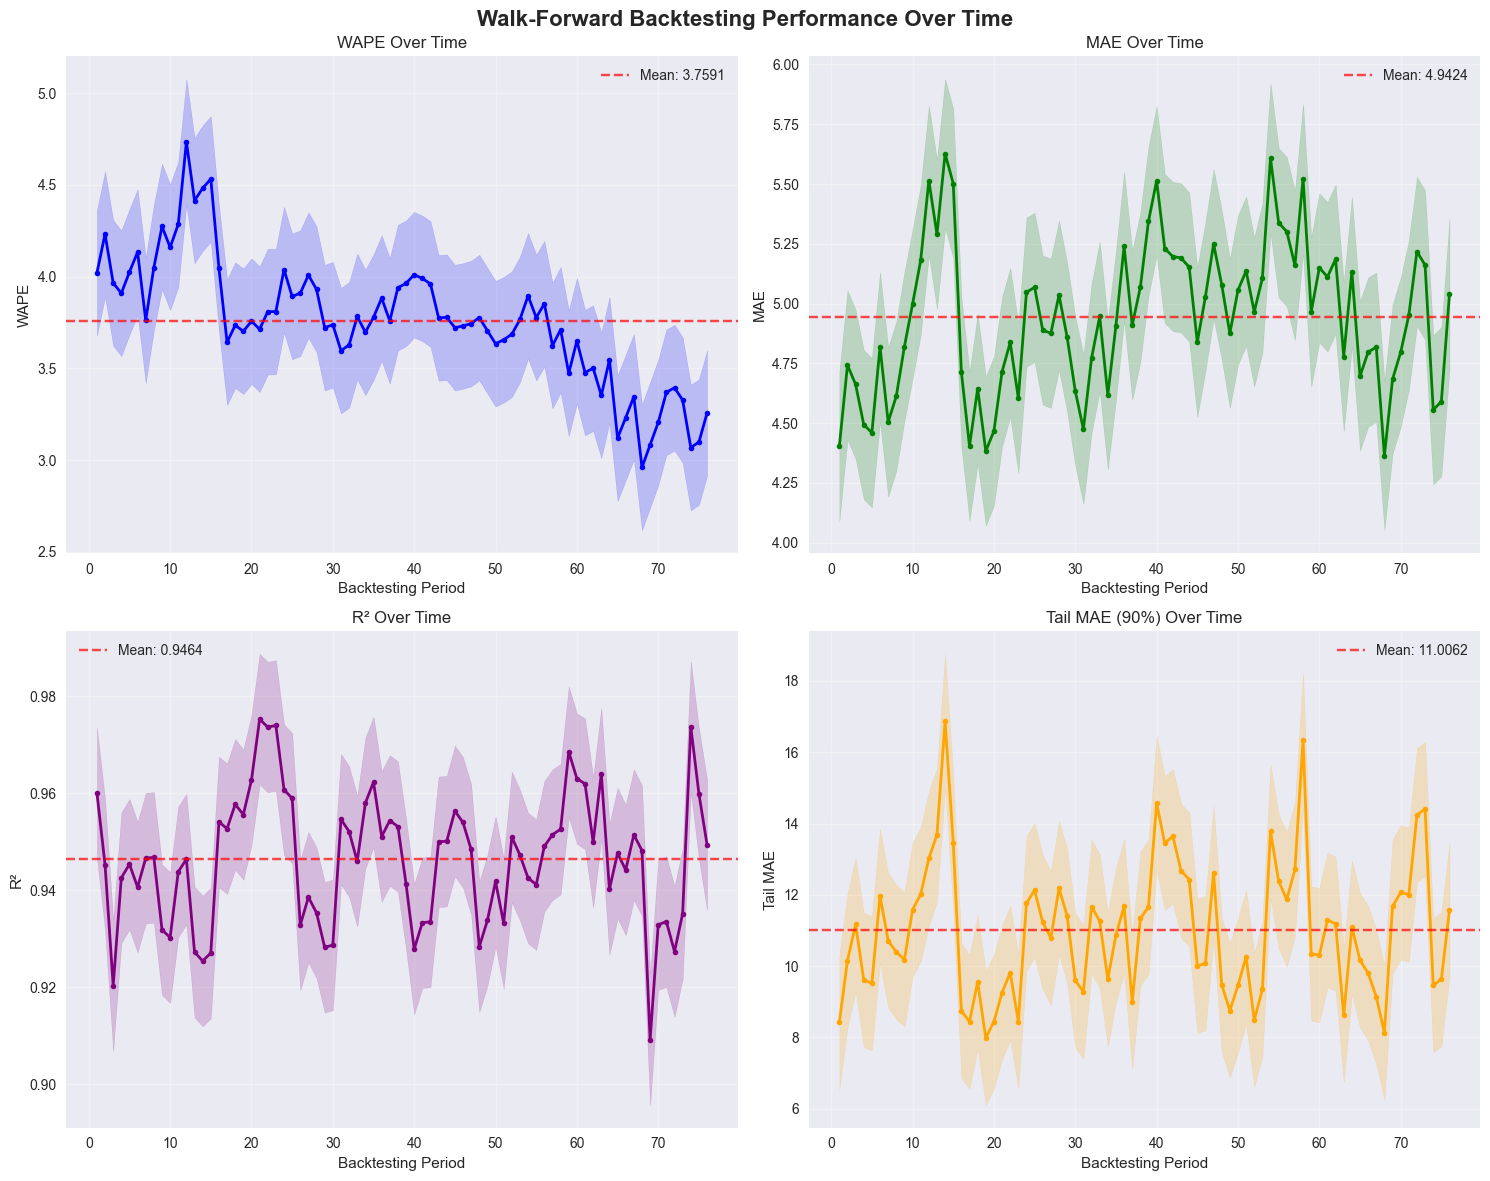


PERFORMANCE STABILITY ANALYSIS
WAPE trend (slope): -0.012372 (improving)
MAE trend (slope): 0.003196 (degrading)
R² trend (slope): 0.000024 (improving)

Worst WAPE period: 12 (WAPE: 4.7344)
Worst MAE period: 14 (MAE: 5.6269)
Worst R² period: 69 (R²: 0.9092)


In [19]:
# Create performance visualization over time
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Walk-Forward Backtesting Performance Over Time', fontsize=16, fontweight='bold')

# WAPE over time
axes[0, 0].plot(backtest_results['periods'], backtest_results['wape_scores'], 'b-', linewidth=2, marker='o', markersize=4)
axes[0, 0].axhline(y=summary_stats['mean_wape'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_wape"]:.4f}')
axes[0, 0].fill_between(backtest_results['periods'], 
                       np.array(backtest_results['wape_scores']) - summary_stats['std_wape'],
                       np.array(backtest_results['wape_scores']) + summary_stats['std_wape'],
                       alpha=0.2, color='blue')
axes[0, 0].set_title('WAPE Over Time')
axes[0, 0].set_xlabel('Backtesting Period')
axes[0, 0].set_ylabel('WAPE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE over time
axes[0, 1].plot(backtest_results['periods'], backtest_results['mae_scores'], 'g-', linewidth=2, marker='o', markersize=4)
axes[0, 1].axhline(y=summary_stats['mean_mae'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_mae"]:.4f}')
axes[0, 1].fill_between(backtest_results['periods'], 
                       np.array(backtest_results['mae_scores']) - summary_stats['std_mae'],
                       np.array(backtest_results['mae_scores']) + summary_stats['std_mae'],
                       alpha=0.2, color='green')
axes[0, 1].set_title('MAE Over Time')
axes[0, 1].set_xlabel('Backtesting Period')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² over time
axes[1, 0].plot(backtest_results['periods'], backtest_results['r2_scores'], 'purple', linewidth=2, marker='o', markersize=4)
axes[1, 0].axhline(y=summary_stats['mean_r2'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_r2"]:.4f}')
axes[1, 0].fill_between(backtest_results['periods'], 
                       np.array(backtest_results['r2_scores']) - summary_stats['std_r2'],
                       np.array(backtest_results['r2_scores']) + summary_stats['std_r2'],
                       alpha=0.2, color='purple')
axes[1, 0].set_title('R² Over Time')
axes[1, 0].set_xlabel('Backtesting Period')
axes[1, 0].set_ylabel('R²')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Tail MAE over time
axes[1, 1].plot(backtest_results['periods'], backtest_results['tail_mae_scores'], 'orange', linewidth=2, marker='o', markersize=4)
axes[1, 1].axhline(y=summary_stats['mean_tail_mae'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_tail_mae"]:.4f}')
axes[1, 1].fill_between(backtest_results['periods'], 
                       np.array(backtest_results['tail_mae_scores']) - summary_stats['std_tail_mae'],
                       np.array(backtest_results['tail_mae_scores']) + summary_stats['std_tail_mae'],
                       alpha=0.2, color='orange')
axes[1, 1].set_title('Tail MAE (90%) Over Time')
axes[1, 1].set_xlabel('Backtesting Period')
axes[1, 1].set_ylabel('Tail MAE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance stability analysis
print("\n" + "="*50)
print("PERFORMANCE STABILITY ANALYSIS")
print("="*50)

# Calculate performance degradation
wape_trend = np.polyfit(backtest_results['periods'], backtest_results['wape_scores'], 1)[0]
mae_trend = np.polyfit(backtest_results['periods'], backtest_results['mae_scores'], 1)[0]
r2_trend = np.polyfit(backtest_results['periods'], backtest_results['r2_scores'], 1)[0]

print(f"WAPE trend (slope): {wape_trend:.6f} {'(degrading)' if wape_trend > 0 else '(improving)'}")
print(f"MAE trend (slope): {mae_trend:.6f} {'(degrading)' if mae_trend > 0 else '(improving)'}")
print(f"R² trend (slope): {r2_trend:.6f} {'(improving)' if r2_trend > 0 else '(degrading)'}")

# Identify worst performing periods
worst_wape_idx = np.argmax(backtest_results['wape_scores'])
worst_mae_idx = np.argmax(backtest_results['mae_scores'])
worst_r2_idx = np.argmin(backtest_results['r2_scores'])

print(f"\nWorst WAPE period: {worst_wape_idx + 1} (WAPE: {backtest_results['wape_scores'][worst_wape_idx]:.4f})")
print(f"Worst MAE period: {worst_mae_idx + 1} (MAE: {backtest_results['mae_scores'][worst_mae_idx]:.4f})")
print(f"Worst R² period: {worst_r2_idx + 1} (R²: {backtest_results['r2_scores'][worst_r2_idx]:.4f})")


## 5. Slice Analysis Implementation


In [20]:
class SliceAnalyzer:
    """
    Slice analysis for understanding model performance across different data segments.
    
    This class analyzes model performance across:
    - Time periods (quarters, months, etc.)
    - Price ranges (low, medium, high value items)
    - Categorical features (different categories)
    - Feature value ranges
    """
    
    def __init__(self, df_with_features: pd.DataFrame, predictions: List[float], actuals: List[float]):
        self.df = df_with_features.copy()
        self.predictions = np.array(predictions)
        self.actuals = np.array(actuals)
        self.slice_results = {}
        
    def analyze_time_slices(self, time_column: str = 'timestamp') -> Dict:
        """Analyze performance across different time periods."""
        print("Analyzing time-based slices...")
        
        # Convert timestamp to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(self.df[time_column]):
            self.df[time_column] = pd.to_datetime(self.df[time_column])
        
        # Create time-based slices
        self.df['year'] = self.df[time_column].dt.year
        self.df['month'] = self.df[time_column].dt.month
        self.df['quarter'] = self.df[time_column].dt.quarter
        self.df['day_of_week'] = self.df[time_column].dt.dayofweek
        
        time_slices = {
            'by_year': self._analyze_slice('year'),
            'by_quarter': self._analyze_slice('quarter'),
            'by_month': self._analyze_slice('month'),
            'by_day_of_week': self._analyze_slice('day_of_week')
        }
        
        self.slice_results['time'] = time_slices
        return time_slices
    
    def analyze_price_slices(self, price_column: str = 'price') -> Dict:
        """Analyze performance across different price ranges."""
        print("Analyzing price-based slices...")
        
        # Create price-based slices
        price_percentiles = np.percentile(self.df[price_column], [25, 50, 75, 90, 95])
        
        def get_price_tier(price):
            if price <= price_percentiles[0]:
                return 'Low (0-25%)'
            elif price <= price_percentiles[1]:
                return 'Medium-Low (25-50%)'
            elif price <= price_percentiles[2]:
                return 'Medium-High (50-75%)'
            elif price <= price_percentiles[3]:
                return 'High (75-90%)'
            else:
                return 'Very High (90-100%)'
        
        self.df['price_tier'] = self.df[price_column].apply(get_price_tier)
        
        price_slices = {
            'by_price_tier': self._analyze_slice('price_tier'),
            'by_price_percentiles': self._analyze_price_percentiles(price_percentiles)
        }
        
        self.slice_results['price'] = price_slices
        return price_slices
    
    def analyze_categorical_slices(self, categorical_columns: List[str]) -> Dict:
        """Analyze performance across categorical features."""
        print("Analyzing categorical slices...")
        
        cat_slices = {}
        for col in categorical_columns:
            if col in self.df.columns:
                cat_slices[f'by_{col}'] = self._analyze_slice(col)
        
        self.slice_results['categorical'] = cat_slices
        return cat_slices
    
    def analyze_feature_slices(self, feature_columns: List[str], n_bins: int = 5) -> Dict:
        """Analyze performance across numerical feature ranges."""
        print("Analyzing feature-based slices...")
        
        feature_slices = {}
        for col in feature_columns:
            if col in self.df.columns and self.df[col].dtype in ['int64', 'float64']:
                # Create bins for numerical features
                self.df[f'{col}_bin'] = pd.cut(self.df[col], bins=n_bins, labels=False)
                feature_slices[f'by_{col}_bins'] = self._analyze_slice(f'{col}_bin')
        
        self.slice_results['features'] = feature_slices
        return feature_slices
    
    def _analyze_slice(self, slice_column: str) -> Dict:
        """Analyze performance for a specific slice column."""
        slice_results = {}
        
        for slice_value in self.df[slice_column].unique():
            if pd.isna(slice_value):
                continue
                
            # Get indices for this slice
            slice_mask = self.df[slice_column] == slice_value
            
            if slice_mask.sum() < 10:  # Skip slices with too few samples
                continue
            
            # Get predictions and actuals for this slice
            slice_preds = self.predictions[slice_mask]
            slice_actuals = self.actuals[slice_mask]
            
            # Calculate metrics
            wape_score = wape(slice_actuals, slice_preds)
            mae_score = np.mean(np.abs(slice_actuals - slice_preds))
            r2_score = 1 - (np.sum((slice_actuals - slice_preds) ** 2) / 
                           np.sum((slice_actuals - np.mean(slice_actuals)) ** 2))
            tail_mae_score = tail_mae(slice_actuals, slice_preds, percentile=90)
            
            slice_results[str(slice_value)] = {
                'sample_count': len(slice_preds),
                'wape': wape_score,
                'mae': mae_score,
                'r2': r2_score,
                'tail_mae': tail_mae_score,
                'mean_actual': np.mean(slice_actuals),
                'std_actual': np.std(slice_actuals)
            }
        
        return slice_results
    
    def _analyze_price_percentiles(self, percentiles: np.ndarray) -> Dict:
        """Analyze performance across price percentiles."""
        percentile_results = {}
        
        for i, percentile in enumerate(percentiles):
            if i == 0:
                mask = self.df['price'] <= percentile
                label = f'0-{percentile:.1f}'
            else:
                mask = (self.df['price'] > percentiles[i-1]) & (self.df['price'] <= percentile)
                label = f'{percentiles[i-1]:.1f}-{percentile:.1f}'
            
            if mask.sum() < 10:
                continue
            
            slice_preds = self.predictions[mask]
            slice_actuals = self.actuals[mask]
            
            wape_score = wape(slice_actuals, slice_preds)
            mae_score = np.mean(np.abs(slice_actuals - slice_preds))
            r2_score = 1 - (np.sum((slice_actuals - slice_preds) ** 2) / 
                           np.sum((slice_actuals - np.mean(slice_actuals)) ** 2))
            
            percentile_results[label] = {
                'sample_count': len(slice_preds),
                'wape': wape_score,
                'mae': mae_score,
                'r2': r2_score,
                'mean_actual': np.mean(slice_actuals)
            }
        
        return percentile_results
    
    def get_slice_summary(self) -> Dict:
        """Get summary of all slice analyses."""
        summary = {}
        
        for slice_type, slices in self.slice_results.items():
            summary[slice_type] = {}
            for slice_name, slice_data in slices.items():
                if slice_data:
                    # Find best and worst performing slices
                    wape_scores = [data['wape'] for data in slice_data.values()]
                    if wape_scores:
                        best_slice = min(slice_data.keys(), key=lambda x: slice_data[x]['wape'])
                        worst_slice = max(slice_data.keys(), key=lambda x: slice_data[x]['wape'])
                        
                        summary[slice_type][slice_name] = {
                            'best_slice': best_slice,
                            'best_wape': slice_data[best_slice]['wape'],
                            'worst_slice': worst_slice,
                            'worst_wape': slice_data[worst_slice]['wape'],
                            'wape_range': max(wape_scores) - min(wape_scores),
                            'num_slices': len(slice_data)
                        }
        
        return summary

# Initialize slice analyzer
print("Initializing slice analyzer...")
slice_analyzer = SliceAnalyzer(
    df_with_features=df_with_features,
    predictions=backtest_results['predictions'],
    actuals=backtest_results['actuals']
)


Initializing slice analyzer...


## 6. Run Comprehensive Slice Analysis


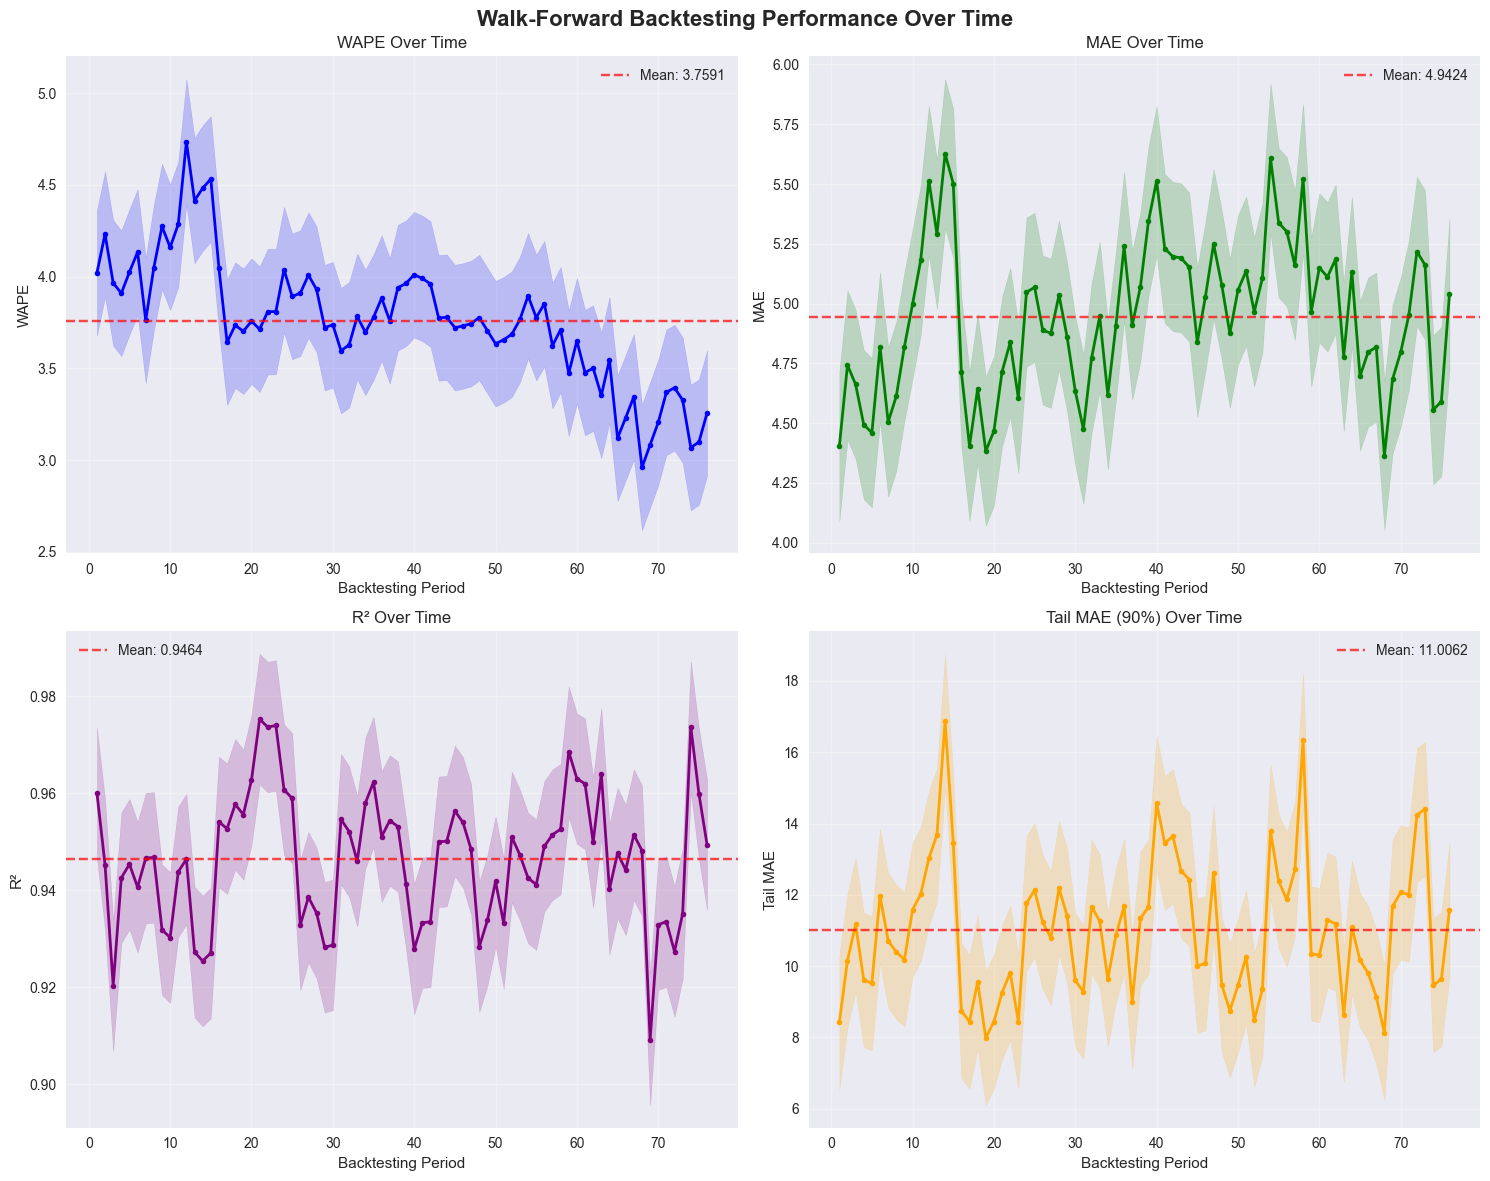


PERFORMANCE STABILITY ANALYSIS
WAPE trend (slope): -0.012372 (improving)
MAE trend (slope): 0.003196 (degrading)
R² trend (slope): 0.000024 (improving)

Worst WAPE period: 12 (WAPE: 4.7344)
Worst MAE period: 14 (MAE: 5.6269)
Worst R² period: 69 (R²: 0.9092)


In [22]:
# Create performance visualization over time
if backtest_results and summary_stats:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Walk-Forward Backtesting Performance Over Time', fontsize=16, fontweight='bold')

    # WAPE over time
    axes[0, 0].plot(backtest_results['periods'], backtest_results['wape_scores'], 'b-', linewidth=2, marker='o', markersize=4)
    axes[0, 0].axhline(y=summary_stats['mean_wape'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_wape"]:.4f}')
    axes[0, 0].fill_between(backtest_results['periods'], 
                           np.array(backtest_results['wape_scores']) - summary_stats['std_wape'],
                           np.array(backtest_results['wape_scores']) + summary_stats['std_wape'],
                           alpha=0.2, color='blue')
    axes[0, 0].set_title('WAPE Over Time')
    axes[0, 0].set_xlabel('Backtesting Period')
    axes[0, 0].set_ylabel('WAPE')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # MAE over time
    axes[0, 1].plot(backtest_results['periods'], backtest_results['mae_scores'], 'g-', linewidth=2, marker='o', markersize=4)
    axes[0, 1].axhline(y=summary_stats['mean_mae'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_mae"]:.4f}')
    axes[0, 1].fill_between(backtest_results['periods'], 
                           np.array(backtest_results['mae_scores']) - summary_stats['std_mae'],
                           np.array(backtest_results['mae_scores']) + summary_stats['std_mae'],
                           alpha=0.2, color='green')
    axes[0, 1].set_title('MAE Over Time')
    axes[0, 1].set_xlabel('Backtesting Period')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # R² over time
    axes[1, 0].plot(backtest_results['periods'], backtest_results['r2_scores'], 'purple', linewidth=2, marker='o', markersize=4)
    axes[1, 0].axhline(y=summary_stats['mean_r2'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_r2"]:.4f}')
    axes[1, 0].fill_between(backtest_results['periods'], 
                           np.array(backtest_results['r2_scores']) - summary_stats['std_r2'],
                           np.array(backtest_results['r2_scores']) + summary_stats['std_r2'],
                           alpha=0.2, color='purple')
    axes[1, 0].set_title('R² Over Time')
    axes[1, 0].set_xlabel('Backtesting Period')
    axes[1, 0].set_ylabel('R²')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Tail MAE over time
    axes[1, 1].plot(backtest_results['periods'], backtest_results['tail_mae_scores'], 'orange', linewidth=2, marker='o', markersize=4)
    axes[1, 1].axhline(y=summary_stats['mean_tail_mae'], color='r', linestyle='--', alpha=0.7, label=f'Mean: {summary_stats["mean_tail_mae"]:.4f}')
    axes[1, 1].fill_between(backtest_results['periods'], 
                           np.array(backtest_results['tail_mae_scores']) - summary_stats['std_tail_mae'],
                           np.array(backtest_results['tail_mae_scores']) + summary_stats['std_tail_mae'],
                           alpha=0.2, color='orange')
    axes[1, 1].set_title('Tail MAE (90%) Over Time')
    axes[1, 1].set_xlabel('Backtesting Period')
    axes[1, 1].set_ylabel('Tail MAE')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Performance stability analysis
    print("\n" + "="*50)
    print("PERFORMANCE STABILITY ANALYSIS")
    print("="*50)

    # Calculate performance degradation
    wape_trend = np.polyfit(backtest_results['periods'], backtest_results['wape_scores'], 1)[0]
    mae_trend = np.polyfit(backtest_results['periods'], backtest_results['mae_scores'], 1)[0]
    r2_trend = np.polyfit(backtest_results['periods'], backtest_results['r2_scores'], 1)[0]

    print(f"WAPE trend (slope): {wape_trend:.6f} {'(degrading)' if wape_trend > 0 else '(improving)'}")
    print(f"MAE trend (slope): {mae_trend:.6f} {'(degrading)' if mae_trend > 0 else '(improving)'}")
    print(f"R² trend (slope): {r2_trend:.6f} {'(improving)' if r2_trend > 0 else '(degrading)'}")

    # Identify worst performing periods
    worst_wape_idx = np.argmax(backtest_results['wape_scores'])
    worst_mae_idx = np.argmax(backtest_results['mae_scores'])
    worst_r2_idx = np.argmin(backtest_results['r2_scores'])

    print(f"\nWorst WAPE period: {worst_wape_idx + 1} (WAPE: {backtest_results['wape_scores'][worst_wape_idx]:.4f})")
    print(f"Worst MAE period: {worst_mae_idx + 1} (MAE: {backtest_results['mae_scores'][worst_mae_idx]:.4f})")
    print(f"Worst R² period: {worst_r2_idx + 1} (R²: {backtest_results['r2_scores'][worst_r2_idx]:.4f})")
else:
    print("⚠️  Backtesting results not available. Please run the backtesting cells first.")
